In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import yfinance as yf
import datetime
from datetime import datetime, timedelta
import requests
import io
import os
import re
import pandas as pd
import time 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.error import HTTPError
import traceback
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
#pip install yfinance

In [3]:
#['TRMB','FTNT','TEAM','GNRC','CRL','INTU','ALGN','ASML','CMG']
news_tables = {}
tickers = ['FTNT','RMD','PAYC','WST','ASML']

In [4]:

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
     # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table
    

In [7]:
ftnt = news_tables['FTNT']
# Get all the table rows tagged in HTML with <tr> into 'mrna_tr'
ftnt_tr = ftnt.findAll('tr')

for i, table_row in enumerate(ftnt_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

5 Stocks Leading the Rally in S&P 500 ETF
Aug-17-21 10:05AM  
Fortinet and HashiCorp Announce FortiManager Integration with Terraform to Automate and Simplify Cloud Security
09:00AM  
Q2 Earnings Fails to Impress Cybersecurity ETFs
Aug-13-21 10:40AM  
Did You Miss Fortinet's (NASDAQ:FTNT) Whopping 813% Share Price Gain?
Aug-06-21 05:38AM  


In [8]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]   
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
#parsed_news

In [9]:
#pip install vader
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jhunt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [11]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['Symbols', 'Date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
df2 = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = df2['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
df2 = df2.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
df2['Date'] = pd.to_datetime(df2.Date).dt.date

df2.head(5)

,Symbols,Date,time,headline,neg,neu,pos,compound
0,FTNT,2021-08-17,10:05AM,5 Stocks Leading the Rally in S&P 500 ETF,0.000,1.000,0.000,0.0000
1,FTNT,2021-08-17,09:00AM,Fortinet and HashiCorp Announce FortiManager I...,0.000,0.844,0.156,0.3400
2,FTNT,2021-08-13,10:40AM,Q2 Earnings Fails to Impress Cybersecurity ETFs,0.262,0.467,0.271,0.0258
3,FTNT,2021-08-06,05:38AM,Did You Miss Fortinet's (NASDAQ:FTNT) Whopping...,0.113,0.493,0.394,0.6124
4,FTNT,2021-08-05,08:30AM,Here's How Much You'd Have If You Invested $10...,0.000,1.000,0.000,0.0000


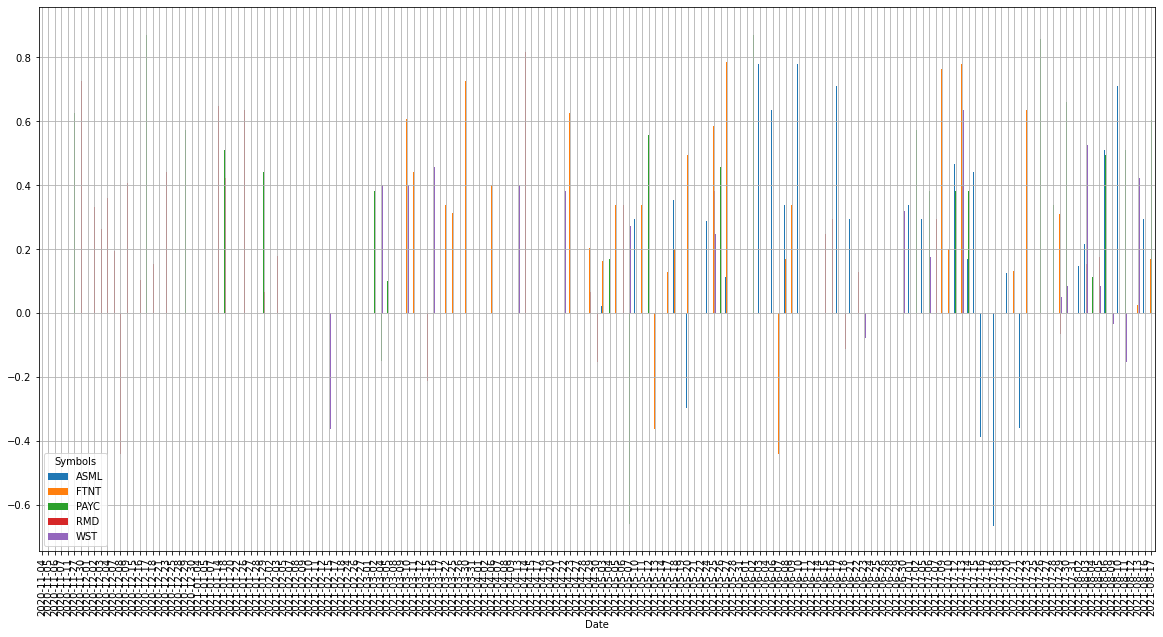

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = df2.groupby(['Symbols','Date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [13]:
df2.reset_index(inplace=True)
df2 = df2.drop(columns=['headline','time','index'])
df2.head(30)

,Symbols,Date,neg,neu,pos,compound
0,FTNT,2021-08-17,0.000,1.000,0.000,0.0000
1,FTNT,2021-08-17,0.000,0.844,0.156,0.3400
2,FTNT,2021-08-13,0.262,0.467,0.271,0.0258
3,FTNT,2021-08-06,0.113,0.493,0.394,0.6124
4,FTNT,2021-08-05,0.000,1.000,0.000,0.0000
5,FTNT,2021-08-04,0.371,0.629,0.000,-0.6486
6,FTNT,2021-08-03,0.000,1.000,0.000,0.0000
7,FTNT,2021-07-30,0.000,1.000,0.000,0.0000
8,FTNT,2021-07-30,0.000,1.000,0.000,0.0000
9,FTNT,2021-07-30,0.000,1.000,0.000,0.0000


In [14]:
df2 = df2.groupby(['Symbols'],as_index=False)['compound'].mean()
df2.head()

,Symbols,compound
0,ASML,0.164421
1,FTNT,0.174143
2,PAYC,0.163749
3,RMD,0.148861
4,WST,0.104647
